# Model Building : GoogLeNet with Inception V3

### GoogleNet (Inception V1) was the winner at the ILSVRC 2014 image classification challenge. It has provided a significant decrease in error rate as compared to previous winners AlexNet (Winner of ILSVRC 2012) and ZF-Net (Winner of ILSVRC 2013) and significantly less error rate than VGG (2014 runner up). This architecture uses techniques such as 1×1 convolutions in the middle of the architecture and global average pooling.

### Let us observe its inner workings using the Keras pre-built inceptionV3 module.

#### First we import all the necessary modules

In [ ]:
# IGNORE ALL WARNINGS
import warnings
warnings.filterwarnings('ignore')

# STANDARD LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# FILE MANIPULATION
from scipy.io import loadmat
import os
import random
import pickle

# UTILITIES
from tqdm.notebook import tqdm

# CNN
import tensorflow as tf
print("TensorFlow version: ", tf.__version__,'\n')

# Keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Check GPU being used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

TensorFlow version:  2.3.0 

Mon Nov 23 03:02:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                           

#### I will use google colab for this notebook. I will be unzipping a compressed file live but this portion depends on your circumstance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/Project Car Formula/5050.zip' -d /content/CZ4042_Project/

Streaming output truncated to the last 5000 lines.
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/06152.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/00480.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/03389.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/06385.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/04034.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/07475.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/07677.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/00518.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/01410.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/working/data/train/0109/06419.jpg  
  inflating: /content/CZ4042_Project/CNNstanfordcars/workin

#### Here some global constants w.r.t images is defined. I also specify the number of epoches.

In [ ]:
# Constants
batch_size = 32
img_height = 224
img_width = 224
IMAGE_SHAPE = (img_height, img_width, 3)
CLASS_NUM = 196

epochs=100

AUTOTUNE = tf.data.experimental.AUTOTUNE # For performance

#### Using Tensorflow 2.3 and Keras in built importing utility, I import the images from the directories and split them. There are 8144 training images, and 20% of them will be used for validation.

In [ ]:
working_dir = '/content/CZ4042_Project/CNNstanfordcars/working'
train_dir = working_dir + '/data/train'
train_ds = keras.preprocessing.image_dataset_from_directory(train_dir, validation_split = 0.2, subset = "training", seed = 123, image_size=(img_height, img_width), batch_size = batch_size)
val_ds = keras.preprocessing.image_dataset_from_directory(train_dir, validation_split = 0.2, subset = "validation", seed = 123, image_size=(img_height, img_width), batch_size = batch_size)

Found 8144 files belonging to 196 classes.
Using 6516 files for training.
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.


#### Let me count the number of unique class targets of the stanford cars dataset. 

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Number of classes: ", num_classes)
print("Classes:")
print(class_names)

Number of classes:  196
Classes:
['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121'

#### Set up a caching area for storing imported data

In [ ]:
# Optimizing for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # Cache, shuffle, and prefetch for train set
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # Same for validation set

#### This is the customised Inception V3 module for GoogLeNet built using conv2d and pooling layers.

In [ ]:
# Inception V3 model for Keras. Reference paper:
# Rethinking the Inception Architecture for Computer Vision(http://arxiv.org/abs/1512.00567) (CVPR 2016)

from tensorflow.python.keras import backend
from tensorflow.python.keras.applications import imagenet_utils
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.layers import VersionAwareLayers
from tensorflow.python.keras.utils import data_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io
from tensorflow.python.util.tf_export import keras_export


WEIGHTS_PATH = (
    'https://storage.googleapis.com/tensorflow/keras-applications/'
    'inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://storage.googleapis.com/tensorflow/keras-applications/'
    'inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

layers = VersionAwareLayers()


def Custom_InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'):

    img_input = layers.Input(shape=input_shape)
    channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed0')

    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed1')

    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D((3, 3),
                                                strides=(1, 1),
                                                padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                                axis=channel_axis,
                                name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3, strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch7x7x3, branch_pool],
                            axis=channel_axis,
                            name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate([branch3x3_1, branch3x3_2],
                                        axis=channel_axis,
                                        name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2],
                                            axis=channel_axis)

        branch_pool = layers.AveragePooling2D((3, 3),
                                                strides=(1, 1),
                                                padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                                axis=channel_axis,
                                name='mixed' + str(9 + i))
    
    if pooling == 'avg':
        x = layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = training.Model(inputs, x, name='inception_v3')

    # Load weights.
    if weights == 'imagenet':
        weights_path = data_utils.get_file(
            'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
            WEIGHTS_PATH_NO_TOP,
            cache_subdir='models',
            file_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)

    return model


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    # Utility function to apply Conv2D and Batch Normalization.

    """
    Arguments:
    x: input tensor.
    filters: filters in `Conv2D`.
    num_row: height of the convolution kernel.
    num_col: width of the convolution kernel.
    padding: padding mode in `Conv2D`.
    strides: strides in `Conv2D`.
    name: name of the ops; will become `name + '_conv'`
    for the convolution and `name + '_bn'` for the
    batch norm layer.

    Returns:
    Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    
    bn_axis = 3 # Channels last
    
    x = layers.Conv2D(filters, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=False,
                      name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x

#### We still have to build a standard CNN but include the custom inceptionV3 above.

In [ ]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
# from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
        preprocessing.Rescaling(1.0 / 255)
    ]
)

# Create a model that includes the augmentation stage
input_shape = (img_height, img_width, 3)
inputs = keras.Input(shape=input_shape)
data_aug = data_augmentation(inputs) # Augment images
data_aug = preprocessing.Rescaling(1.0 / 255)(data_aug) # Rescale image values to [0, 1]

# load the InceptionV3 network, ensuring the head FC layer sets are left off
baseModel = Custom_InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)(data_aug)


# construct the head of the model that will be placed on top of the base model
headModel = Dropout(0.5)(baseModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=inputs, outputs=headModel)

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.1)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

#### Add an optimizer and compile it

In [ ]:
# optimizer = keras.optimizers.Adam()
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.1)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])

#### Checkpoint the building process in case of reusability

In [ ]:
checkpoint_path = '/content/drive/MyDrive/CZ4042_Project/training/Custom_InceptionV3_Test1'

# Create a callback that saves the model's weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=0)

#### Time to train the whole model.

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose = 2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
204/204 - 26s - loss: 5.3255 - accuracy: 0.0051 - val_loss: 5.2885 - val_accuracy: 0.0055
Epoch 2/100
204/204 - 20s - loss: 5.2806 - accuracy: 0.0068 - val_loss: 5.2839 - val_accuracy: 0.0043
Epoch 3/100
204/204 - 21s - loss: 5.2803 - accuracy: 0.0074 - val_loss: 5.2778 - val_accuracy: 0.0092
Epoch 4/100
204/204 - 20s - loss: 5.2796 - accuracy: 0.0068 - val_loss: 5.2790 - val_accuracy: 0.0092
Epoch 5/100
204/204 - 20s - loss: 5.2790 - accuracy: 0.0075 - val_loss: 5.2786 - val_accuracy: 0.0092
Epoch 6/100
204/204 - 20s - loss: 5.2779 - accuracy: 0.0083 - val_loss: 5.2788 - val_accuracy: 0.0080
Epoch 7/100
204/204 - 20s - loss: 5.2774 - accuracy: 0.0083 - val_loss: 5.2790 - val_accuracy: 0.0086
Epoch 8/100
204/204 - 20s - loss: 5.2769 - accuracy: 0.0075 - val_loss: 5.2783 - val_accuracy: 0.0086
Epoch 9/100
204/204 - 21s - loss: 5.2768 - accuracy: 0.0080 - val_loss: 5.2760 - val_accuracy: 0.0098
Epoch 10/100
204/204 - 20s - loss: 5.2708 - accuracy: 0.0087 - val_loss: 5.2751 - 

#### Extract history to plot accuracy and loss graphs

In [ ]:
# Extract Loss Values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract Accuracy Values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

instanced_variables = [train_loss, val_loss, train_acc, val_acc]

#### Dump model into pickle file

In [ ]:
#Save model
model.save('/content/drive/MyDrive/CZ4042_Project/Custom_InceptionV3_1')

#Save variables
filename = '/content/drive/MyDrive/CZ4042_Project/Custom_InceptionV3_1_variables'
outfile = open(filename,'wb')
pickle.dump(instanced_variables, outfile)
outfile.close() 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CZ4042_Project/Custom_InceptionV3_1/assets


#### Plot the graphs

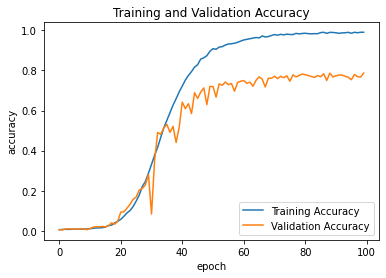

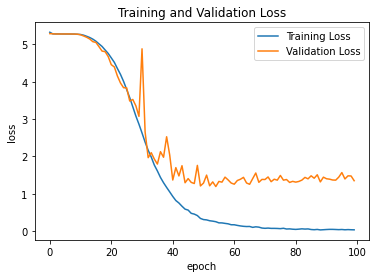

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/CZ4042_Project/InceptionV3_main_2_acc.pdf')
plt.savefig('/content/drive/MyDrive/CZ4042_Project/InceptionV3_main_2_acc.png')
plt.show()
plt.close()

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/CZ4042_Project/InceptionV3_main_2_loss.pdf')
plt.savefig('/content/drive/MyDrive/CZ4042_Project/InceptionV3_main_2_loss.png')
plt.show()

#### Evaluate on the test set

In [ ]:
test_ds = keras.preprocessing.image_dataset_from_directory(working_dir + '/data/test', seed = 123, image_size=(img_height, img_width), batch_size = batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8041 files belonging to 196 classes.


In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.save_weights('/content/drive/MyDrive/CZ4042_Project/InceptionV3_main_2')

In [ ]:
test_loss, test_acc = model.evaluate(
    x=test_ds, 
    y=None, 
    batch_size=batch_size)
print("Test accuracy:", test_acc)

252/252 [==============================] - 12s 48ms/step - loss: 1.3092 - accuracy: 0.7891
Test accuracy: 0.7890809774398804


In [ ]:
val_loss_, val_acc_ = model.evaluate(
    x=val_ds, 
    y=None, 
    batch_size=batch_size)
print("Validation accuracy:", val_acc_)

51/51 [==============================] - 1s 29ms/step - loss: 1.3503 - accuracy: 0.7869
Validation accuracy: 0.7868550419807434


#### Predict on a test image and see the result

Actual car:    Daewoo Nubira Wagon 2002
Predicted car: Daewoo Nubira Wagon 2002 with a 100.00 percent confidence.
Actual Class:    82
Predicted Class: 82


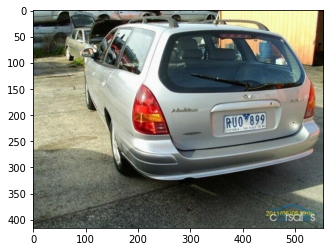

In [ ]:
import cv2
path_to_train_matfile = '/content/CZ4042_Project/CNNstanfordcars/devkit/cars_train_annos.mat'
raw_train_data = loadmat(path_to_train_matfile)
path_to_test_matfile = '/content/CZ4042_Project/CNNstanfordcars/devkit/cars_test_annos_withlabels.mat'
raw_test_data = loadmat(path_to_test_matfile)
train_annots_data = np.transpose(raw_train_data["annotations"])
test_annots_data = np.transpose(raw_test_data["annotations"])
# print(train_annots_data.shape)
# print(test_annots_data.shape)

random_index = random.randint(0, 8041)
test_path = '/content/CZ4042_Project/CNNstanfordcars/cars_test/cars_test'
relative_path = (test_annots_data[random_index,:])[0][5][0]
random_car = cv2.imread(os.path.join(test_path, relative_path))
car_rgb = cv2.cvtColor(random_car, cv2.COLOR_BGR2RGB)
plt.imshow(car_rgb)
path_to_labels_matfile = '/content/CZ4042_Project/CNNstanfordcars/devkit/cars_meta.mat'
raw_labels_data = loadmat(path_to_labels_matfile)

img = keras.preprocessing.image.load_img(
    os.path.join(test_path, relative_path), target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = predictions[0]

print("Actual car:   ", raw_labels_data["class_names"][0][test_annots_data[random_index][0][4][0][0] - 1][0])
print("Predicted car: {} with a {:.2f} percent confidence."
    .format(raw_labels_data["class_names"][0][int(class_names[np.argmax(score)]) - 1][0], 100 * np.max(score)))
print("Actual Class:   ", test_annots_data[random_index][0][4][0][0])
print("Predicted Class:", int(class_names[np.argmax(score)]))